In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import gpflow
gpflow.config.set_default_float(np.float32)
from shapely import geometry
import pointpats
import shapely
from time import time

from joblib import Parallel, delayed

from sgptools.utils.tsp import run_tsp # TSP/VRP solver for initial path planning
from sgptools.objectives import *
from sgptools.methods import get_method
from sgptools.kernels import get_kernel
from sgptools.kernels.attentive import *
from sgptools.utils.gpflow import get_model_params
from sgptools.utils.data import Dataset
from sklearn.metrics import pairwise_distances

np.random.seed(1234)
tf.random.set_seed(1234)

/home/itskalvik/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-11-20 22:56:43.934486: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 22:56:43.991840: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-20 22:56:44.331673: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-20 22:56:44.643191: E ex

In [2]:
# Method to extract lengthscales map from attentive non stationary kernel
def predict_lengthscales(X, lengthscales, kernel):
        preds = np.zeros(len(X))
        repre1 = kernel.get_representations(X)
        for i in range(len(lengthscales)):
                attention = tf.tensordot(repre1[:, i],
                                         tf.transpose(repre1[:, i]),
                                         axes=0)
                preds += np.diag(attention) * lengthscales[i]
        return preds

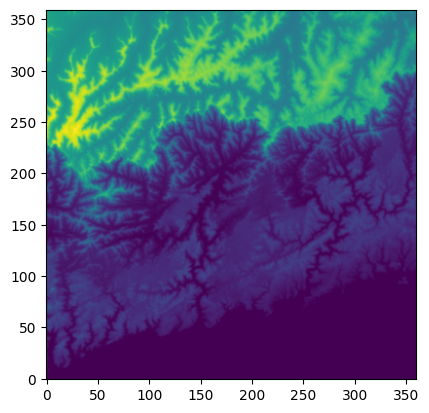

Original dataset shape: (360, 360)
Training data shapes (X, y): (5000, 2), (5000, 1)
Testing data shapes (X, y): (20000, 2), (20000, 1)
Candidate data shape (X): (150, 2)
Dataset loaded and preprocessed successfully.


2025-11-20 22:57:05.041819: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# Load data
data = np.load("N17E073.npy")
plt.imshow(data.T, origin="lower")
plt.show()

dataset = Dataset(data=data, dtype=np.float32,
                  num_train=5000, num_test=20000)
X_train, y_train = dataset.get_train()
x_max, y_max = X_train.max(axis=0)
x_min, y_min = X_train.min(axis=0)
env = geometry.Polygon([[x_max, y_max], [x_min, y_max], [x_min, y_min], [x_max, y_min]])

lengthscales = np.linspace(1, 10, 10)

# Train GP/Kernel 
_, noise_variance, kernel, model = get_model_params(
    X_train=X_train, y_train=y_train, 
    kernel=get_kernel('Attentive')(lengthscales=lengthscales),
    optimizer='tf.Nadam',
    learning_rate=1e-2,
    max_steps=1000,
    return_model=True,
    verbose=False)

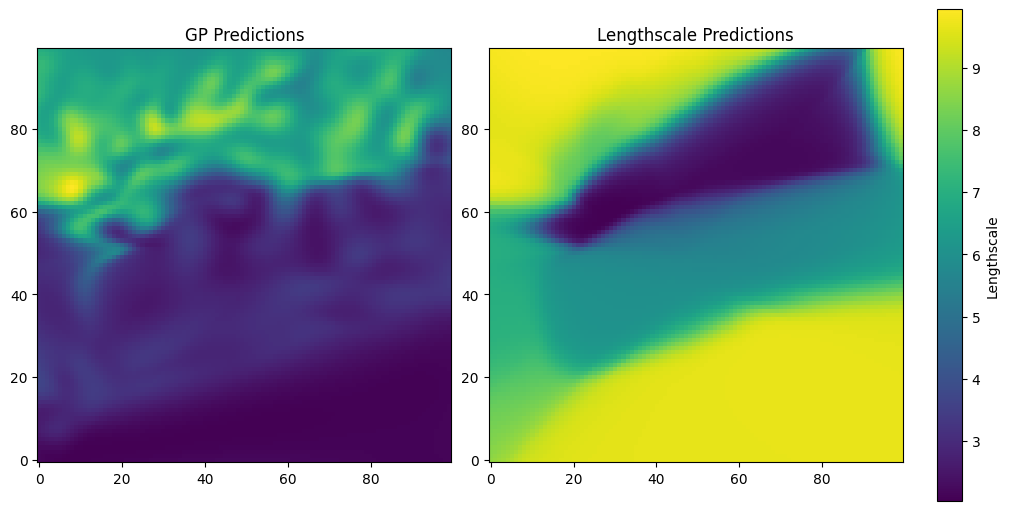

In [4]:
# Plot GP prediction and lengthscale map
X_test, _ = dataset.get_test()
grid_x, grid_y = np.mgrid[min(X_test[:, 0]):max(X_test[:, 0]):100j, 
                          min(X_test[:, 1]):max(X_test[:, 1]):100j]
X_test = np.stack([grid_x, grid_y], axis=-1)
x_dim, y_dim = X_test.shape[:2]
X_test = X_test.reshape(-1, 2).astype(X_train.dtype)

mean, std = model.predict_f(X_test)
lengthscale_preds = predict_lengthscales(X_test, lengthscales, kernel)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].imshow(mean.numpy().reshape(x_dim, y_dim).T, origin="lower")
axes[0].set_title("GP Predictions")
axes[0].set_aspect('equal')

# Second subplot — test data
sc2 = axes[1].imshow(lengthscale_preds.reshape(x_dim, y_dim).T, origin="lower")
axes[1].set_title("Lengthscale Predictions")
axes[1].set_aspect('equal')

# Shared colorbar
fig.colorbar(sc2, ax=axes, orientation='vertical', 
             fraction=0.05, pad=0.04, label='Lengthscale')

plt.show()


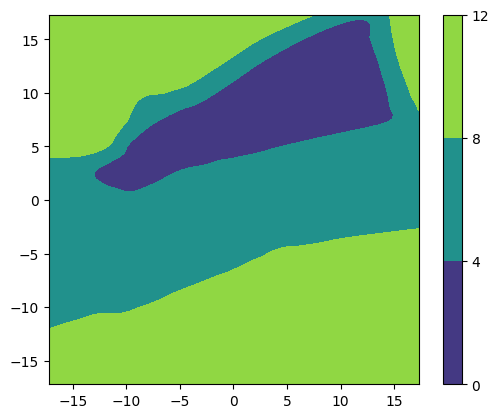

In [5]:
# Get contour
grid_x, grid_y = X_test.reshape(x_dim, y_dim, 2)[:, :, 0], X_test.reshape(x_dim, y_dim, 2)[:, :, 1]
grid_z = lengthscale_preds.reshape(x_dim, y_dim)
cs = plt.contourf(grid_x, grid_y, grid_z, levels=1)
plt.gca().set_aspect('equal')
plt.colorbar()

336 33600


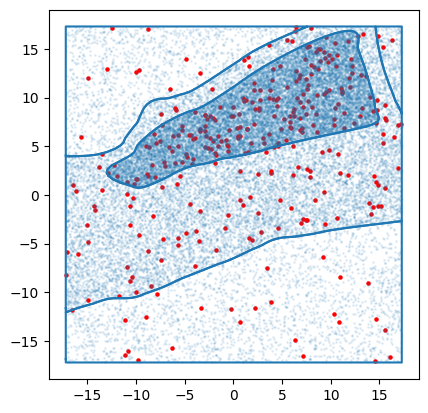

In [6]:
# Extract each polygon with holes from the contour map
polygons = []
levels = []
for contour_path, level in zip(cs.get_paths(), [2, 4, 8]): 
    for idx, cp in enumerate(contour_path.to_polygons()):
        x = cp[:,0]
        y = cp[:,1]
        polygon = geometry.Polygon([(i[0], i[1]) for i in zip(x,y)])

        if idx == 0:
            polygons.append(polygon)
            levels.append(level)
        else:
            if polygons[-1].intersects(polygon):
                # Remove holes
                polygons[-1] = polygons[-1].difference(polygon)
            else:
                # Save disjoint polygons
                polygons.append(polygon)
                levels.append(level)

sum_p = polygons[0]
for i in range(1, len(polygons)):
    sum_p = shapely.union(sum_p, polygons[i])

# Plot each polygon and sample points proportional to the lengthscale density of each polygon
pts_list = []
train_pts = []
num_train_pts = 10000
for l, p in zip(levels, polygons):
    x_ext, y_ext = p.exterior.xy
    plt.plot(x_ext, y_ext, c='C0')

    for interior in p.interiors:
        x_int, y_int = interior.xy
        plt.plot(x_int, y_int, color='C0')

    c_area = np.pi*((l/2)**2)
    size = int(np.ceil(p.area/c_area))*3
    pts = pointpats.random.poisson(p, size=size)
    t_pts = pointpats.random.poisson(p, size=size*100)

    if size == 1:
        pts_list.append([pts])
    else:
        pts_list.append(pts)
    train_pts.append(t_pts)

pts_list = np.concatenate(pts_list).astype(X_train.dtype)
train_pts = np.concatenate(train_pts).astype(X_train.dtype)
print(len(pts_list), len(train_pts))
plt.scatter(pts_list[:, 0], pts_list[:, 1], s=5, c='r')
plt.scatter(train_pts[:, 0], train_pts[:, 1], s=1, c='C0', alpha=0.1)
plt.gca().set_aspect('equal')
plt.show()

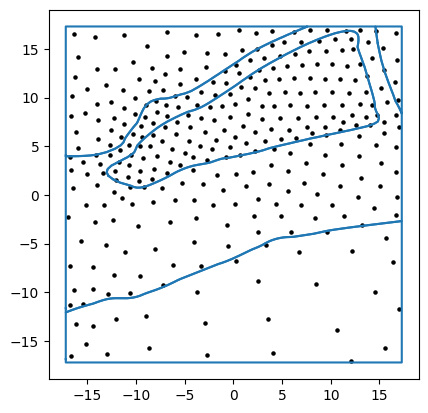

In [7]:
method = get_method('ContinuousSGP')
sp_optimizer = method(
    len(pts_list), 
    train_pts, 
    kernel,
    noise_variance, 
    X_init=pts_list.astype(X_train.dtype),
)

# 4. Run the optimization
X_sol = sp_optimizer.optimize()
X_sol = X_sol.reshape(-1, 2)

# Plot each polygon and solution points
for l, p in zip(levels, polygons):
    x_ext, y_ext = p.exterior.xy
    plt.plot(x_ext, y_ext, c='C0')

    for interior in p.interiors:
        x_int, y_int = interior.xy
        plt.plot(x_int, y_int, color='C0')

plt.scatter(X_sol[:, 0], X_sol[:, 1], s=5, c='k')
plt.gca().set_aspect('equal')
plt.show()

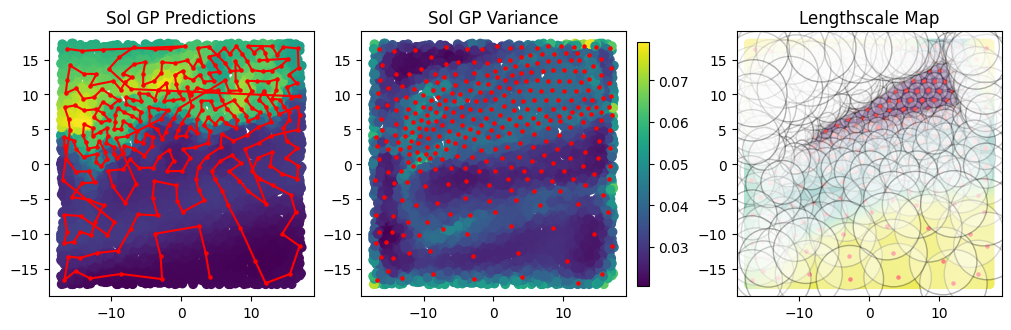

In [8]:
y_sol, _ = model.predict_f(X_sol)
_, _, _, model_sol = get_model_params(
    X_train=X_sol, y_train=y_sol, 
    kernel=kernel,
    max_steps=0,
    return_model=True,
    verbose=False)

mean, var = model_sol.predict_f(X_train)
sol_path, _ = run_tsp(X_sol, time_limit=15)
sol_lengthscales = predict_lengthscales(X_sol, lengthscales, kernel)


fig, axes = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].scatter(X_train[:, 0], X_train[:, 1], c=mean.numpy())
axes[0].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
axes[0].plot(sol_path[0][:, 0], sol_path[0][:, 1], c='r')
axes[0].set_title("Sol GP Predictions")
axes[0].set_aspect('equal')

# Second subplot — variance
sc2 = axes[1].scatter(X_train[:, 0], X_train[:, 1], c=var.numpy())
axes[1].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
axes[1].set_title("Sol GP Variance")
axes[1].set_aspect('equal')

# Fix colorbar size
cbar = fig.colorbar(sc2, ax=axes[1], fraction=0.046, pad=0.04)

# Third subplot — lengthscale
axes[2].scatter(X_test[:, 0], X_test[:, 1], c=lengthscale_preds)
axes[2].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
axes[2].set_title("Lengthscale Map")
axes[2].set_aspect('equal')

for pt, d in zip(X_sol, sol_lengthscales):
    circle = patches.Circle(pt, 
                            d/2, 
                            edgecolor='k', 
                            facecolor='w', 
                            alpha=0.3)
    axes[2].add_patch(circle)

axes[2].set_xlim(axes[0].get_xlim())
axes[2].set_ylim(axes[0].get_ylim())

plt.show()

In [9]:
import numpy as np
from shapely import union_all  # or from shapely.ops import unary_union
from joblib import Parallel, delayed

def coverage_area(polygons, env):
    """
    Get effective coverage area from selected sensing locations.

    Parameters
    ----------
    polygons : Sequence[shapely.geometry.base.BaseGeometry]
        Polygons representing the observable sensing area at each sensing location.
    env : shapely.geometry.Polygon
        Polygon representing the extent of the environment.

    Returns
    -------
    float
        The area of the union of `polygons` clipped to `env`.
    """
    if not polygons:
        return 0.0

    # Union once, then intersect with environment
    union_poly = union_all(polygons)
    inside = env.intersection(union_poly)
    return inside.area


def get_dist(path_points):
    """
    Compute total Euclidean length of a polyline.

    Parameters
    ----------
    path_points : array-like, shape (n_points, 2)
        Sequence of 2D points.

    Returns
    -------
    float
        Sum of segment lengths.
    """
    pts = np.asarray(path_points, dtype=float)

    if len(pts) < 2:
        return 0.0

    segment_vectors = np.diff(pts, axis=0)
    segment_lengths = np.linalg.norm(segment_vectors, axis=1)
    return float(np.sum(segment_lengths))


def approx_dist(p_nodes, x):
    """
    Approximate tour length after inserting point x into an existing route.

    Heuristic:
      - Find the nearest existing node.
      - Try inserting x before or after that node.
      - Return the shorter of the two resulting path lengths.

    Parameters
    ----------
    p_nodes : array-like, shape (n_nodes, 2)
        Existing route points (in order).
    x : array-like, shape (2,)
        New point to be inserted.

    Returns
    -------
    float
        Approximate tour length with x inserted.
    """
    p_nodes = np.asarray(p_nodes, dtype=float)
    x = np.asarray(x, dtype=float)

    n = len(p_nodes)
    if n == 0:
        return 0.0
    if n == 1:
        return get_dist(np.vstack([p_nodes[0], x]))

    # Distances from x to each existing node (avoid sklearn dependency)
    dists = np.linalg.norm(p_nodes - x, axis=1)
    idx = int(np.argmin(dists))

    # Build candidate sequences
    if idx == n - 1:  # nearest is last
        seq1 = np.vstack([p_nodes[:idx+1], x])          # insert after last
        seq2 = np.vstack([p_nodes[:idx], x, p_nodes[idx]])  # insert before last
    elif idx == 0:  # nearest is first
        seq1 = np.vstack([p_nodes[0], x, p_nodes[1]])       # insert after first
        seq2 = np.vstack([x, p_nodes])                      # insert before first
    else:  # nearest is in the middle
        seq1 = np.vstack([p_nodes[:idx+1], x, p_nodes[idx+1:]])  # insert after idx
        seq2 = np.vstack([p_nodes[:idx], x, p_nodes[idx:]])      # insert before idx

    dist1 = get_dist(seq1)
    dist2 = get_dist(seq2)

    # Choose the better insertion and compute the full route length
    if dist1 < dist2:
        new_route = seq1
    else:
        new_route = seq2

    return get_dist(new_route)


def compute_deltas(x, G, distance, area, env):
    """
    Compute change in distance and area when adding candidate x to current set G.
    """
    # Current + candidate centroids
    locs = np.array([loc.centroid.coords[0] for loc in G] + [x.centroid.coords[0]])
    new_dist = approx_dist(locs[:-1], locs[-1])
    distance_delta = distance - new_dist

    new_area = coverage_area(G + [x], env)
    area_delta = area - new_area

    return distance_delta, area_delta


def gcb(candidates, env, distance_budget):
    """
    Greedy coverage + budget (GCB) selection.

    Parameters
    ----------
    candidates : list of shapely geometries
        Candidate sensing regions (e.g., buffered points).
    env : shapely.geometry.Polygon
        Environment extent.
    distance_budget : float
        Maximum allowed tour length.

    Returns
    -------
    list
        Ordered list of selected sensing regions (G).
    """
    V = list(candidates)  # remaining candidates
    G = []

    # --- 1) Add initial sensing location: the one with max coverage alone ---
    if not V:
        return G

    area_deltas = [coverage_area([x], env) for x in V]
    idx = int(np.argmax(area_deltas))

    G.append(V[idx])
    distance = 0.0
    area = area_deltas[idx]
    del V[idx]

    # --- 2) Add remaining sensing locations greedily ---
    # Stop when no candidates left or we cover 99% of environment
    target_area = env.area * 0.99

    while V and area < target_area:
        # Parallel evaluation of distance/area changes for each remaining candidate
        results = Parallel(n_jobs=-1)(
            delayed(compute_deltas)(x, G, distance, area, env) for x in V
        )

        distance_deltas, area_deltas = zip(*results)
        distance_deltas = np.array(distance_deltas, dtype=float)
        area_deltas = np.array(area_deltas, dtype=float)

        # Avoid division by zero; candidates with zero distance change are penalized
        safe_dist = np.where(distance_deltas == 0.0, np.inf, distance_deltas)
        ratios = area_deltas / safe_dist

        for _ in range(len(V)):
            idx = int(np.argmax(ratios))
            chosen = V[idx]

            # Remove from candidate set whether accepted or not
            del V[idx]
            ratios = np.delete(ratios, idx)

            # Recompute TSP route including the chosen candidate
            locs = np.array([loc.centroid.coords[0] for loc in G + [chosen]])

            _, dist_list, indices_list = run_tsp(
                locs,
                initial_route=[list(range(1, len(locs) + 1))],
                solution_limit=10,
                return_indices=True,
            )

            new_distance = dist_list[0]
            if new_distance <= distance_budget:
                # Accept candidate, reorder G to match TSP path
                G.append(chosen)
                order = indices_list[0]
                G = [G[i] for i in order]

                area = coverage_area(G, env)
                distance = new_distance
                break

    return G


# Example usage: generate circles centered at candidate locations
# with radius proportional to the lengthscale at each point.
# ----------------------------------------------------------------
candidates = [
    geometry.Point(pt).buffer(d / 2.0)
    for pt, d in zip(pts_list, predict_lengthscales(pts_list, lengthscales, kernel))
]
sol = gcb(candidates, env, distance_budget=1000.0)

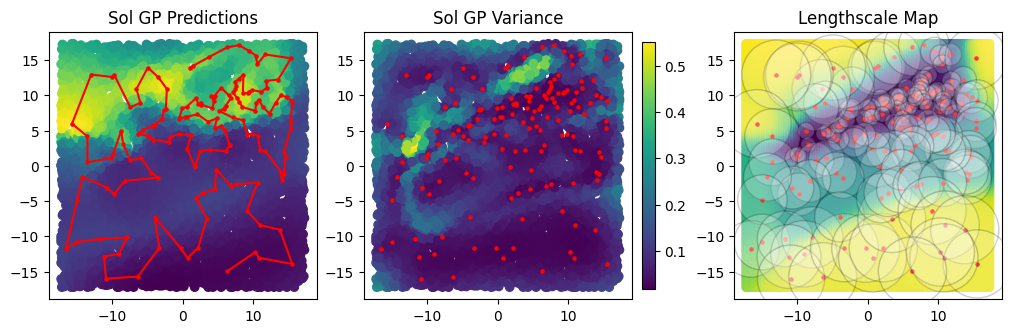

In [10]:
locs = np.array([loc.centroid.coords[0] for loc in sol])
X_sol = locs.astype(X_train.dtype)
y_sol, _ = model.predict_f(X_sol)
_, _, _, model_sol = get_model_params(
    X_train=X_sol, y_train=y_sol, 
    kernel=kernel,
    max_steps=0,
    return_model=True,
    verbose=False)

mean, var = model_sol.predict_f(X_train)
sol_path = [locs]
sol_lengthscales = predict_lengthscales(X_sol, lengthscales, kernel)


fig, axes = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].scatter(X_train[:, 0], X_train[:, 1], c=mean.numpy())
axes[0].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
axes[0].plot(sol_path[0][:, 0], sol_path[0][:, 1], c='r')
axes[0].set_title("Sol GP Predictions")
axes[0].set_aspect('equal')

# Second subplot — variance
sc2 = axes[1].scatter(X_train[:, 0], X_train[:, 1], c=var.numpy())
axes[1].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
axes[1].set_title("Sol GP Variance")
axes[1].set_aspect('equal')

# Fix colorbar size
cbar = fig.colorbar(sc2, ax=axes[1], fraction=0.046, pad=0.04)

# Third subplot — lengthscale
axes[2].scatter(X_test[:, 0], X_test[:, 1], c=lengthscale_preds)
axes[2].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
axes[2].set_title("Lengthscale Map")
axes[2].set_aspect('equal')

for pt, d in zip(X_sol, sol_lengthscales):
    circle = patches.Circle(pt, 
                            d/2, 
                            edgecolor='k', 
                            facecolor='w', 
                            alpha=0.2)
    axes[2].add_patch(circle)

axes[2].set_xlim(axes[0].get_xlim())
axes[2].set_ylim(axes[0].get_ylim())

plt.show()